In [12]:
import pandas as pd
import numpy as np

In [111]:
X_y = pd.read_csv('ads_train_sorted.csv')

In [112]:
y = X_y.y_buy
X = X_y.drop(['Unnamed: 0','y_buy'],1)

## Q4

这里将会使用五种预测模型：逻辑回归、SVM、决策树、随机森林和梯度提升树来训练数据，从而选择出一种最优分类器，其中每种分类器的超参数将使用GridSearch寻找，最后使用训练集找到的最优模型会使用验证数据集来验证。

第一步将从之前清洗过的训练集里分出选取模型的新训练集和验证集：

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=0)

第二步使用GridSearch寻找各个预测模型的最优超参数并给出当前模型的最优成绩，由于是分类数据，最优成绩将从四个维度给出：'roc_auc', 'average_precision', 'precision', 'recall'。其中，最具有综合正确性的roc_auc将被用于作为交叉验证时的指标，同时防止过拟合，另外的'precision'和'recall'可用于特殊商业分析关注点使用。

In [49]:
from sklearn.model_selection import GridSearchCV

In [114]:
def fit_model(X_train, y_train, model, param_grid=None):
    
    grid = GridSearchCV(model, param_grid, 
                            scoring=('roc_auc', 'average_precision', 'precision', 'recall'),
                            refit='roc_auc', cv=10, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

In [115]:
def my_gridsearchCV(X_train, y_train, model, param_grid):
    grid = fit_model(X_train, y_train, model, param_grid=param_grid)
    
    best_params_idx = grid.cv_results_['params'].index(grid.best_params_)

    print('Best parameter(s): {}'.format(grid.best_params_))
    print('Best ROC-AUC: {}'.format(grid.best_score_))
    print('Average precision: {}'.format(grid.cv_results_['mean_test_average_precision'][best_params_idx]))
    print('Precision: {}'.format(grid.cv_results_['mean_test_precision'][best_params_idx]))
    print('Recall: {}'.format(grid.cv_results_['mean_test_recall'][best_params_idx]))
    
    return grid

In [116]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression

print('Results of Logistic Regression:')
param_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3, 2, 6)}
grid_lr = my_gridsearchCV(X_train, y_train, LogisticRegression(), param_lr)

Results of Logistic Regression:
Best parameter(s): {'C': 0.1, 'penalty': 'l2'}
Best ROC-AUC: 0.8963740329704244
Average precision: 0.882082354397873
Precision: 0.8140965227912211
Recall: 0.9136985886611205


In [117]:
from sklearn.svm import LinearSVC

print('Results of SVM:')
param_svc = {'C': np.logspace(-3, 2, 6)}
grid_svc = my_gridsearchCV(X_train, y_train, LinearSVC(), param_svc)

Results of SVM:
Best parameter(s): {'C': 0.001}
Best ROC-AUC: 0.8876459479888597
Average precision: 0.8859848362458272
Precision: 0.8588525539008749
Recall: 0.8901395512066225


In [118]:
from sklearn.tree import DecisionTreeClassifier

print('Results of Decision Tree:')
param_tree = {'max_depth': range(1, 7)}
grid_tree = my_gridsearchCV(X_train, y_train, DecisionTreeClassifier(random_state=0), param_tree)

Results of Decision Tree:
Best parameter(s): {'max_depth': 6}
Best ROC-AUC: 0.9768667125053213
Average precision: 0.9745162624949305
Precision: 0.929828598317353
Recall: 0.9566010886095112


In [119]:
from sklearn.ensemble import RandomForestClassifier

print('Results of Random Forest:')
param_rf = {'max_depth': range(1, 7)}
grid_rf = my_gridsearchCV(X_train, y_train, RandomForestClassifier(random_state=0), param_rf)

Results of Random Forest:
Best parameter(s): {'max_depth': 6}
Best ROC-AUC: 0.987640910619392
Average precision: 0.987578156345099
Precision: 0.9493160884237419
Recall: 0.9642351864467429


In [120]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from xgboost import XGBClassifier

print('Results of Gradient Boosting:')
param_gb = {'max_depth': range(1, 5)}
grid_gb = my_gridsearchCV(X_train, y_train, XGBClassifier(), param_gb)

Results of Gradient Boosting:
Best parameter(s): {'max_depth': 4}
Best ROC-AUC: 0.9975847463325579
Average precision: 0.9974632737086422
Precision: 0.9742567523956126
Recall: 0.9853954294915465


根据以上显示，深度为4的梯度提升树拥有最优表现。之后将使用此模型进行重要特征选取：

In [79]:
import matplotlib.pyplot as plt

def feature_selection(grid, model_type, X_train, y_train):
    
    features = X_train.columns
    
    # collect the best fit model
    model = grid.best_estimator_
    model.fit(X_train, y_train)
    
    # collect feature importances/coefficients
    if model_type == 'tree':
        coef = model.feature_importances_
    if model_type == 'linear':
        coef = model.coef_[0]
        
    # sort descendingly
    coef_idx = np.argsort(coef)[::-1]
    
    colors=['red'if c>0 else 'blue' for c in np.sort(-coef)]
    
    _ = plt.figure(figsize=(15, 6))
    _ = plt.bar(features[coef_idx], height=np.sort(coef)[::-1], color=colors)
    _ = plt.xlabel('Features')
    if model_type == 'tree':
        _ = plt.ylabel('Feature Importance')
    if model_type == 'linear':
        _ = plt.ylabel('Coefficients')
    _ = plt.title('Classifier: ' + str(model))
    _ = plt.xticks(rotation=90)

    return features, coef_idx

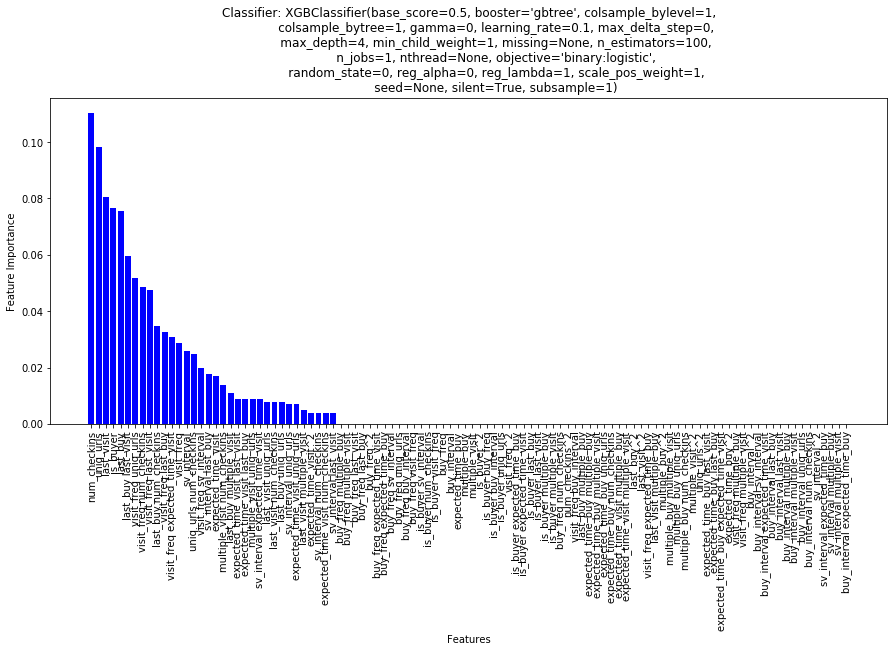

In [121]:
_, coef_idx_gb = feature_selection(grid_gb, 'tree', X_train, y_train)

In [122]:
imp_features = X_train.columns[coef_idx_gb][:20]
imp_features

Index(['num_checkins', 'uniq_urls', 'last_visit', 'is_buyer', 'last_buy',
       'last_buy last_visit', 'visit_freq uniq_urls',
       'visit_freq num_checkins', 'visit_freq last_visit',
       'last_buy num_checkins', 'visit_freq last_buy',
       'visit_freq expected_time_visit', 'visit_freq', 'sv_interval',
       'uniq_urls num_checkins', 'visit_freq sv_interval',
       'sv_interval last_buy', 'expected_time_visit',
       'multiple_visit num_checkins', 'last_buy multiple_visit'],
      dtype='object')

由此可见几个非连续特征（'num_checkins', 'uniq_urls', 'last_visit', 'is_buyer', 'last_buy'）对是否购物有很大影响，其次一些二元混合特征对分类也有影响，新增特征里二元一次特征不具有很强的影响。关于特征影响的正负性可以由逻辑回归分类的结论作为参考，但由于逻辑回归与梯度提升树的分类标准不同，逻辑回归给出的正负性只具有在线性分类上的大致参考作用。

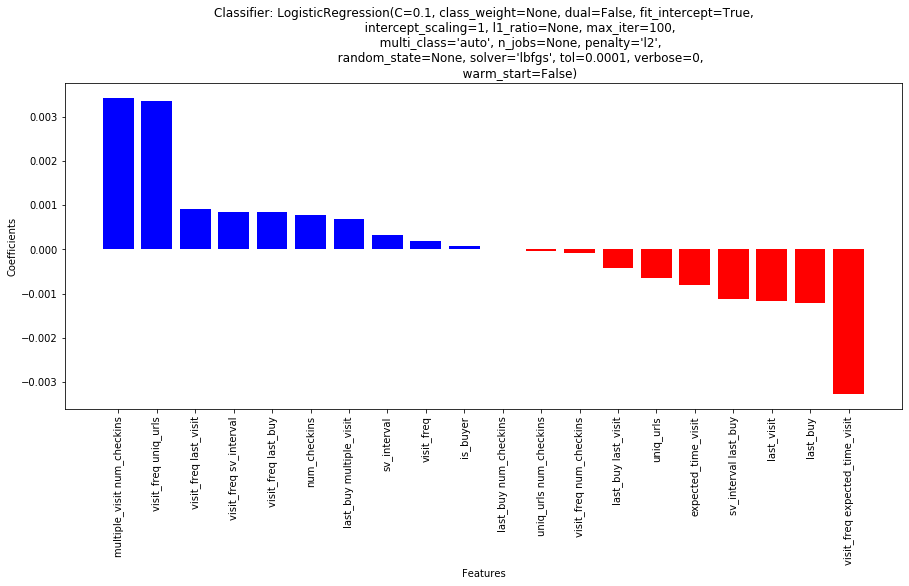

In [123]:
_, coef_idx_lr = feature_selection(grid_lr, 'linear', X_train[imp_features], y_train)

最后使用验证集对训练出来的最优模型进行验证。可以看到，无论是作为整体成绩f1_score还是分别precision和recall都表现优秀。

In [126]:
from sklearn.metrics import classification_report

y_true = y_val
y_pred = grid_gb.predict(X_val)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      4017
           1       0.97      0.98      0.98      4017

    accuracy                           0.98      8034
   macro avg       0.98      0.98      0.98      8034
weighted avg       0.98      0.98      0.98      8034



## Q5

In [100]:
test = pd.read_csv('Python数据清洗预测实操题/ads_test.csv').drop('sample_id',1)

In [127]:
X_test = test.drop('y_buy',1).fillna(value=0)

In [128]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_test_poly = poly.fit_transform(X_test)
col = poly.get_feature_names(input_features=X_test.columns)

In [129]:
X_test_final = pd.DataFrame(columns=col,data=X_test_poly).drop('1',1)

In [130]:
test_label = grid_gb.predict(X_test_final)

In [131]:
test_prob = grid_gb.predict_proba(X_test_final)

In [146]:
test.y_buy = test_label
test['y_buy_prob'] = test_prob.T[1]

In [147]:
test.to_csv('ads_test_predicted.csv')